In [2]:
import pyccl as ccl
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import CubicSpline
from scipy.interpolate import RegularGridInterpolator
import pandas as pd
import zipfile
import pandas as pd
from scipy.integrate import odeint
from scipy.signal import savgol_filter
from configobj import ConfigObj

from os.path import basename
#from HiCOLA import Frontend

In [2]:
"""In this file we are extracting the boost for cubic galileon
from HI realized I never checked iCOLA backend output files"""

'In this file we are extracting the boost for cubic galileon\nfrom HI realized I never checked\xa0iCOLA backend output files'

In [3]:
def find_idxnearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return np.int(idx)

# Look at phase pair

In [4]:
''' Define useful functions'''

def create_params(f, E, h, omegas):
    '''
    Get parameters k, g from f, E and cosmo
    Inputs:
    f --> fphi
    E --> EdS
    omegas --> [b, c, r] * h^2
    
    Outputs:
    k --> k1dS
    g --> g31dS
    '''
    
    # cosmological constant density
    o_DE = h**2 - omegas[0] - omegas[1] - omegas[2]
    O_L = (1-f)*o_DE/ h**2
    
    # k and g
    alpha = 1 - O_L/E**2
    k = -6*alpha
    g = 2*alpha
    
    return k, g

def hypercube_arrays(txt):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi)
    returns two arrays, one for numerical and one for horndeski array
    # numerical - [h , wr , wb , wc, n_s , A_s]
    # horndeski - [f_phi, H0, k_1, g_31]
    """
    h = 0.67
    wb = 0.0223
    wr = 4.28e-5
    
    hcube = np.loadtxt(txt).T
    wm = hcube[0]
    n_s = hcube[1]
    A_s = hcube[2]
    E_dS = hcube[3]
    f_phi = hcube[4]
    k1 , g31 = create_params(f_phi, E_dS, h, [wb,wm - wb,wr])
    arr_hor = [f_phi, 1/E_dS, k1, g31]
    arr_num = [h*np.ones(len(wm)), wr*np.ones(len(wm)), wb*np.ones(len(wm)), wm - wb, n_s, A_s]
    
    return arr_hor, arr_num

Text(0, 0.5, '$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

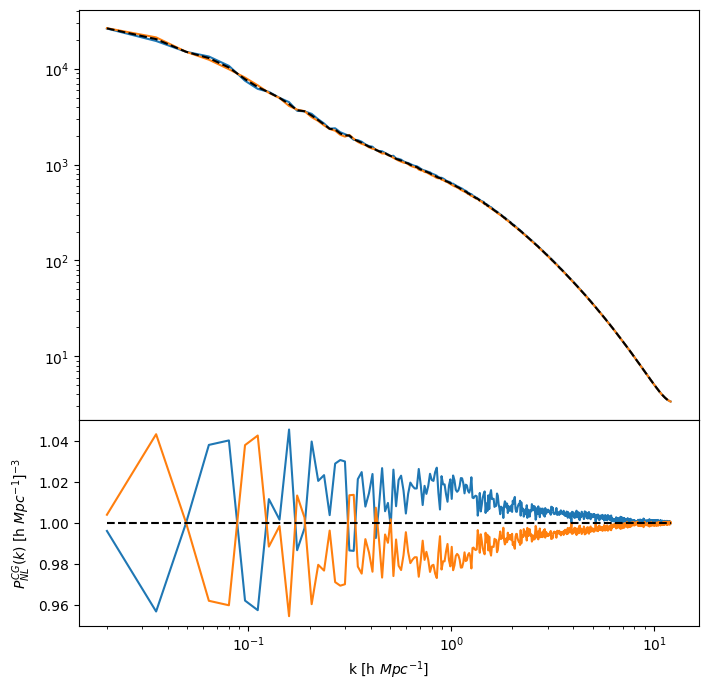

In [5]:
"""Plotting phase pair z = 0"""

fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,8),height_ratios=[2,1])
fig.subplots_adjust(hspace=0,wspace=0)

for i in range(1):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_pp,Pk_Lin_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    ax[0].plot(k,Pk_NL)
    ax[0].plot(k,Pk_NL_pp)
    ax[0].plot(k,(Pk_NL+ Pk_NL_pp)/2, "k--")

    ax[1].plot(k,Pk_NL/((Pk_NL+ Pk_NL_pp)/2))
    ax[1].plot(k,Pk_NL_pp/((Pk_NL+ Pk_NL_pp)/2))
    ax[1].plot(k,(Pk_NL+ Pk_NL_pp)/2/((Pk_NL+ Pk_NL_pp)/2), "k--")

ax[0].set_xscale("log")
ax[0].set_yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")

Text(0, 0.5, 'Boost residual')

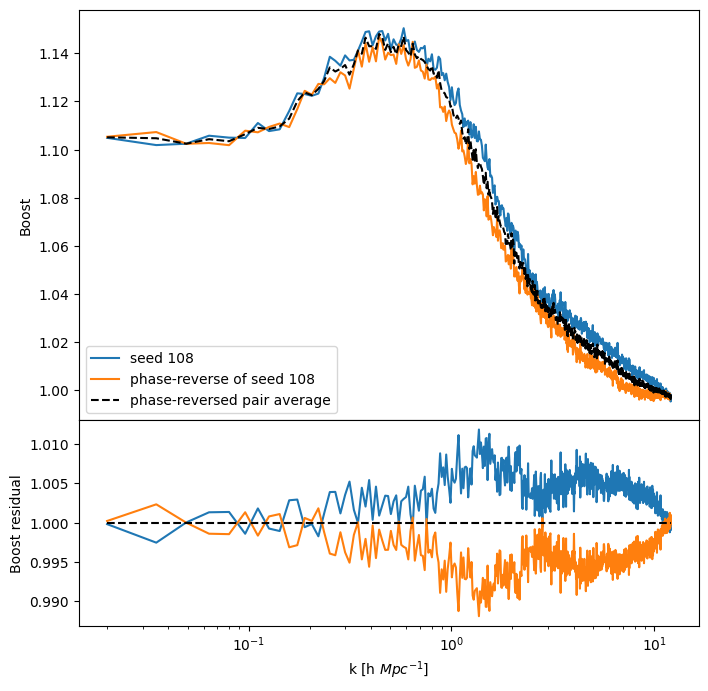

In [29]:
"""Plotting phase pair z = 0"""

fig, ax = plt.subplots(2,1, sharex=True, figsize=(8,8),height_ratios=[2,1])
fig.subplots_adjust(hspace=0,wspace=0)

for i in range(1):
    i = 1
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_pp,Pk_Lin_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_GR_pp,Pk_Lin_GR_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    
    ax[0].plot(k,Pk_NL/Pk_NL_GR, label="seed 108")
    ax[0].plot(k,Pk_NL_pp/Pk_NL_GR_pp, label="phase-reverse of seed 108")
    ax[0].plot(k,(Pk_NL+ Pk_NL_pp)/(Pk_NL_GR+ Pk_NL_GR_pp), "k--", label="phase-reversed pair average")

    ax[1].plot(k,Pk_NL/Pk_NL_GR/((Pk_NL+ Pk_NL_pp)/(Pk_NL_GR+ Pk_NL_GR_pp)))
    ax[1].plot(k,Pk_NL_pp/Pk_NL_GR_pp/((Pk_NL+ Pk_NL_pp)/(Pk_NL_GR+ Pk_NL_GR_pp)))
    ax[1].plot(k,np.ones(len(k)), "k--")

ax[0].set_xscale("log")
ax[0].set_ylabel("Boost")

ax[0].legend()
plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("Boost residual")

# Account for different growth at z=49 (initial conditions)

## From the gravity model file

In [15]:
sample_new = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker').T
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker'
a_n = hypercube_arrays(txt)
cmap = matplotlib.colormaps['viridis']

In [22]:
def hypercube_arrays(txt):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi)
    returns two arrays, one for numerical and one for horndeski array
    # numerical - [h , wr , wb , wc, n_s , A_s]
    # horndeski - [f_phi, H0, k_1, g_31]
    """
    hcube = np.loadtxt(txt).T

    wb = 0.0223*np.ones(len(hcube[0]))
    wr = wr_funct(T_CMB)*np.ones(len(hcube[0]))
    
    n_s = hcube[1]
    A_s = hcube[2]
    h = hcube[3]
    wm = hcube[0]*h**2


    arr_num = [h, wr, wb, wm - wb, n_s, A_s]
    
    return arr_num

def wr_funct(T_CMB):
    return 4.48150052e-7*T_CMB**4 *(1+ 3.044*7/8 * (4/11)**(4/3))

T_CMB = 2.72548 # K.split(',')

In [5]:
gravitymodel_kp00001 = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_14_tracker/gravitymodel_my_new_Hi-COLA_simulation_14_tracker_k0.00001.txt')
gravitymodel_k10 = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_14_tracker/gravitymodel_my_new_Hi-COLA_simulation_14_tracker_k10.0.txt')

gravitymodel_kp00001_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_14_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_14_GR_tracker_k0.00001.txt')
gravitymodel_k10_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_14_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_14_GR_tracker_k10.0.txt')

print(gravitymodel_kp00001.shape)

(200, 11)


Text(0.5, 0, 'z')

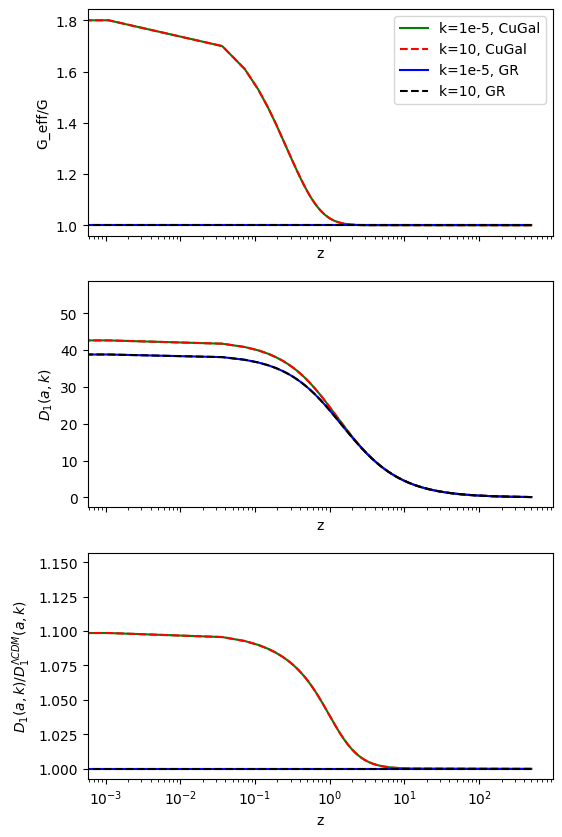

In [6]:
f, ax = plt.subplots(3,1, sharex=True, sharey=False,figsize=(6, 10))

z_array = 1/gravitymodel_k10_GR.T[0] - 1

ax[0].semilogx(z_array, gravitymodel_kp00001.T[1], "g", label="k=1e-5, CuGal")
ax[0].semilogx(z_array, gravitymodel_k10.T[1], "r--", label="k=10, CuGal")
ax[0].semilogx(z_array, gravitymodel_kp00001_GR.T[1], "b", label="k=1e-5, GR")
ax[0].semilogx(z_array, gravitymodel_k10_GR.T[1], "k--", label="k=10, GR")

ax[0].set_ylabel("G_eff/G")
ax[0].set_xlabel("z")
ax[0].legend()

ax[1].semilogx(z_array, gravitymodel_kp00001.T[2], "g", label="k=1e-5, CuGal")
ax[1].semilogx(z_array, gravitymodel_k10.T[2], "r--", label="k=10, CuGal")
ax[1].semilogx(z_array, gravitymodel_kp00001_GR.T[2], "b", label="k=1e-5, GR")
ax[1].semilogx(z_array, gravitymodel_k10_GR.T[2], "k--", label="k=10, GR")

z_49 = z_array[find_idxnearest(z_array, 499)]

#ax[1].semilogx([z_49,z_49], [0,40], "k--")
#ax[1].semilogx([z_array[0],z_array[0]], [0,40], "k--")

ax[1].set_ylabel(r"$D_1(a,k)$")
ax[1].set_xlabel("z")
#ax[1].legend()

ax[2].semilogx(z_array, gravitymodel_kp00001.T[2]/gravitymodel_kp00001_GR.T[2], "g", label="k=1e-5, CuGal")
ax[2].semilogx(z_array, gravitymodel_k10.T[2]/gravitymodel_k10_GR.T[2], "r--", label="k=10, CuGal")
ax[2].semilogx(z_array, gravitymodel_kp00001_GR.T[2]/gravitymodel_kp00001_GR.T[2], "b", label="k=1e-5, GR")
ax[2].semilogx(z_array, gravitymodel_k10_GR.T[2]/gravitymodel_k10_GR.T[2], "k--", label="k=10, GR")

ax[2].set_ylabel(r"$D_1(a,k)/D_1^{\Lambda CDM}(a,k)$")
ax[2].set_xlabel("z")

37
14


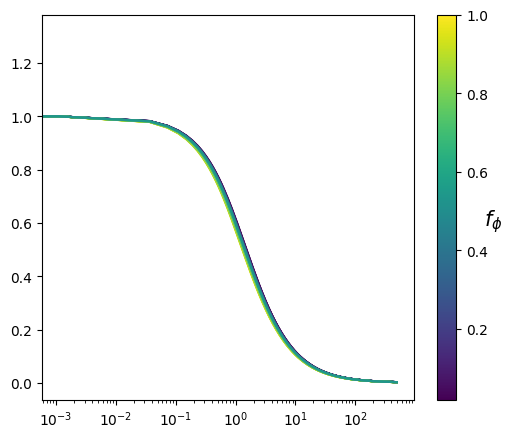

In [17]:
f, ax = plt.subplots(1,1, sharex=True, sharey=False,figsize=(6, 5))

theta = sample_new[-1]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))
cbar = f.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)

ax.semilogx(z_array, gravitymodel_GR[2]/gravitymodel_GR[2][find_idxnearest(z_array, 0)],"k", label="GR")

for i in range(50):
    
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T
    ax.semilogx(z_array, gravitymodel[2]/gravitymodel[2][find_idxnearest(z_array, 0)], label="CuGal",  color = cmap(frac0[i]))

#print(gravitymodel[2]/gravitymodel[2][-1])
#print(z_array)

37
14


Text(0.5, 0, 'a')

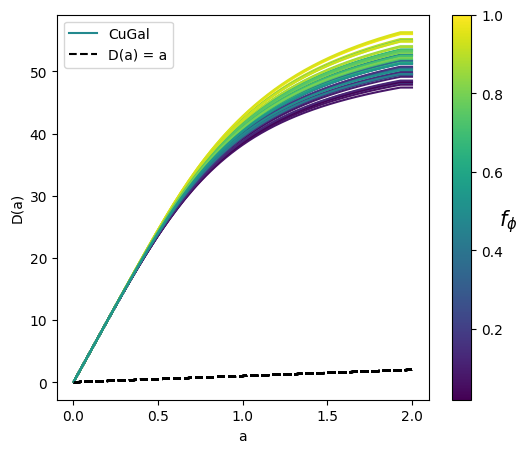

In [19]:
f, ax = plt.subplots(1,1, sharex=True, sharey=False,figsize=(6, 5))

theta = sample_new[-1]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))

cbar = f.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)


for i in range(50):
    
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T
    ax.plot(1/(z_array+1), gravitymodel[2],  color = cmap(frac0[i]))
    ax.plot(1/(z_array+1),1/(z_array+1), "k--")

plt.legend(["CuGal" , "D(a) = a"])

ax.set_ylabel("D(a)")
ax.set_xlabel("a")
#print(gravitymodel[2]/gravitymodel[2][-1])
#print(z_array)

37
14


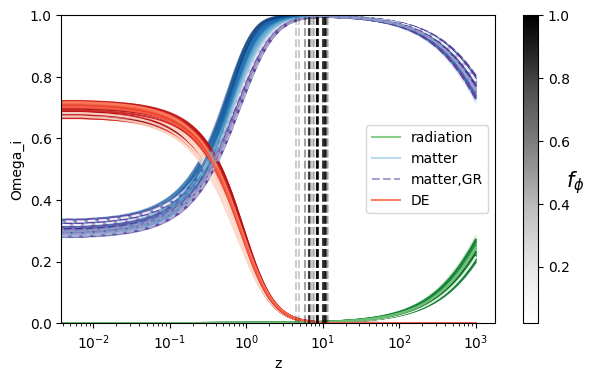

In [25]:
## Plotting ##

fig, ax = plt.subplots(1,1, figsize=(7,4),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

mu_arr = []
Omega_m = []
E_CuGal = []
E_LCDM = []

z_matterdom = []
z_matterdom_gr = []

# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
for i in range(50):

    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_expansion.txt".format(i))
    
    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    Omega_m.append(sample_new[0][i])
    E_CuGal.append(E_a_today)
    E_LCDM.append(E_a_GR)
    
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    coupling = force_today.T[2]
    mu_arr.append(coupling + 1)
    cmap = matplotlib.colormaps['Greens']
    ax.plot(1/a_today -1, wr*a_today**(-4)/E_a_today**2/h**2, alpha=0.9, color = cmap(frac0[i]))
    cmap = matplotlib.colormaps['Blues']
    ax.plot(1/a_today -1, wm*a_today**(-3)/E_a_today**2/h**2, alpha=0.5, color = cmap(frac0[i]))

    cmap = matplotlib.colormaps['Purples']
    ax.plot(1/a_today -1, wm*a_today**(-3)/E_a_GR**2/h**2, alpha=1,linestyle="--", color = cmap(frac0[i]))
    
    cmap = matplotlib.colormaps['Reds']
    ax.plot(1/a_today -1, ((h**2 - wm -wr)/E_a_today**2)/h**2, alpha=0.9, color=cmap(frac0[i]))

    z_matterdom.append((1/a_today -1)[np.argmax(wm*a_today**(-3)/E_a_today**2/h**2)])
    z_matterdom_gr.append((1/a_today -1)[np.argmax(wm*a_today**(-3)/E_a_GR**2/h**2)])

ax.plot([z_matterdom,z_matterdom], [0,1], "k--", alpha=0.2)

ax.set_xlabel("z")

ax.legend(["radiation", "matter", "matter,GR", "DE"])
ax.set_ylabel(r"Omega_i")
ax.set_xscale("log")
ax.set_ylim(0,1.0)
theta = sample_new[-1]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))

cmap = matplotlib.colormaps['Greys']

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)




Text(0, 0.5, '$D^{CuGal}(z)$')

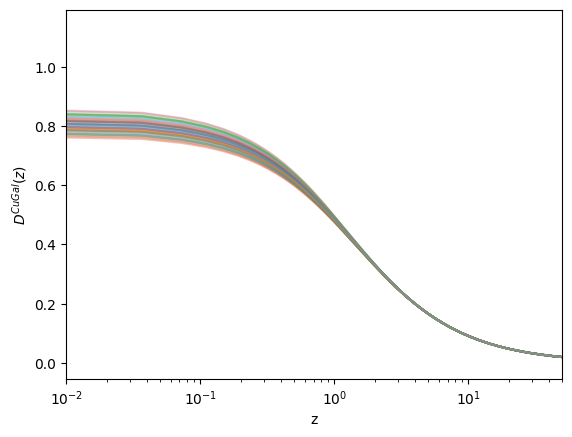

In [26]:
for i in range(50):
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T

    plt.plot(z_array, gravitymodel[2] / (CubicSpline(1/(z_array+1), gravitymodel[2])(1/(z_matterdom[i]+1)) / (1/(z_matterdom[i]+1))) , alpha=0.3)

#plt.legend(["CuGal", "LCDM"])
plt.xlabel("z")
plt.xscale("log")
plt.xlim(1e-2,50)
plt.ylabel(r"$D^{CuGal}(z)$")



Text(0, 0.5, '$D^{CuGal}(z)/D^{LCDM}(z)$')

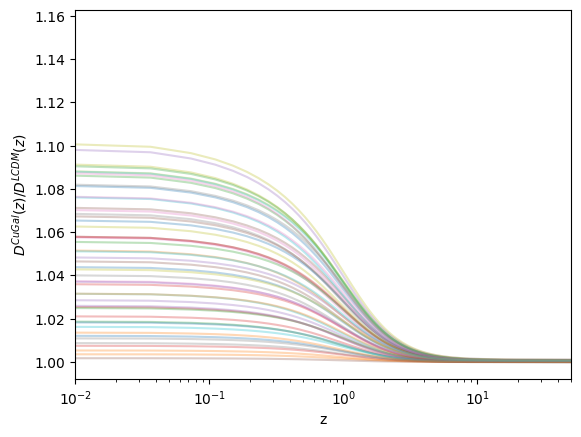

In [27]:
for i in range(50):
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T

    plt.plot(z_array, gravitymodel[2] / (CubicSpline(1/(z_array+1), gravitymodel[2])(1/(z_matterdom[i]+1)) / (1/(z_matterdom[i]+1))) /
             (gravitymodel_GR[2] / (CubicSpline(1/(z_array+1), gravitymodel_GR[2])(1/(z_matterdom_gr[i]+1)) / (1/(z_matterdom_gr[i]+1)))), alpha=0.3)

#plt.legend(["CuGal", "LCDM"])
plt.xlabel("z")
plt.xscale("log")
plt.xlim(1e-2,50)
plt.ylabel(r"$D^{CuGal}(z)/D^{LCDM}(z)$")



Text(0, 0.5, '$D(z)$')

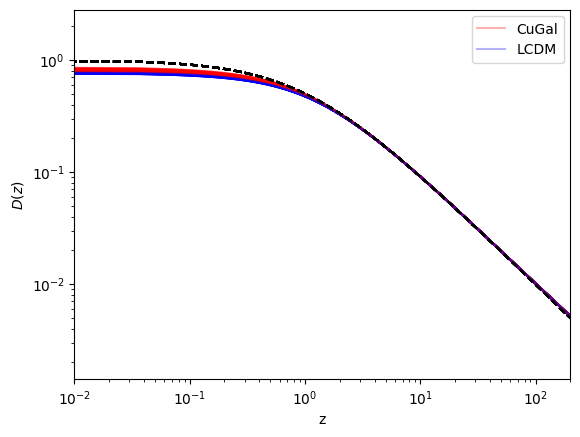

In [28]:
for i in range(50):
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T


    plt.plot(z_array, gravitymodel[2] / (CubicSpline(1/(z_array+1),gravitymodel[2])(1/(z_matterdom[i]+1)) / (1/(z_matterdom[i]+1))) ,"r", alpha=0.3)

    plt.plot(z_array, gravitymodel_GR[2] / (CubicSpline(1/(z_array+1),gravitymodel_GR[2])(1/(z_matterdom_gr[i]+1)) / (1/(z_matterdom_gr[i]+1))) ,"b", alpha=0.3)
    plt.plot(z_array, 1/(z_array+1), "k--")

plt.legend(["CuGal", "LCDM"])
plt.xlabel("z")
plt.xscale("log")
plt.yscale("log")

plt.xlim(1e-2,200)
plt.ylabel(r"$D(z)$")



In [29]:
ratio_growth = []
for i in range(50):
    gravitymodel = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_tracker_k10.0.txt'.format(i,i)).T
    gravitymodel_GR = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/gravitymodel_my_new_Hi-COLA_simulation_{}_GR_tracker_k10.0.txt'.format(i,i)).T
    
    D_a_norm = gravitymodel[2] / (CubicSpline(1/(z_array+1),gravitymodel[2])(1/(z_matterdom[i]+1)) / (1/(z_matterdom[i]+1)))

    D_a_norm_GR = gravitymodel_GR[2] / (CubicSpline(1/(z_array+1),gravitymodel_GR[2])(1/(z_matterdom_gr[i]+1)) / (1/(z_matterdom_gr[i]+1)))
    
    
    # We have D_norm(a) = D_(a) * D(a_matterdom)/a - below we ignore the a factor because it is the same in both
    ratio_growth.append(D_a_norm[find_idxnearest(z_array, 49)]/D_a_norm_GR[find_idxnearest(z_array, 49)])



/tmp/ipykernel_1368965/84250641.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])


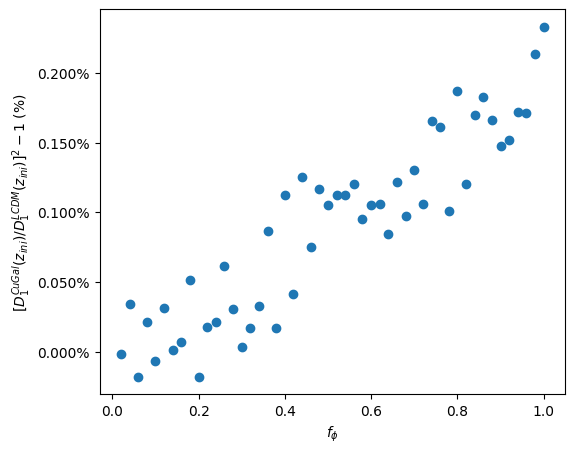

In [31]:
f_phi = sample_new[-1]
f, ax = plt.subplots(1,1, sharex=True, sharey=False,figsize=(6, 5))


ax.scatter(f_phi, (np.array(ratio_growth)**2 - 1))
ax.set_ylabel(r"$[D_1^{CuGal}(z_{ini})/D_1^{LCDM}(z_{ini})]^2 -1$ (%)")
ax.set_xlabel(r"$f_\phi$")

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])


plt.show()

## From the frontend files (LH, for comparison)

37
14
0.9673
0.8959


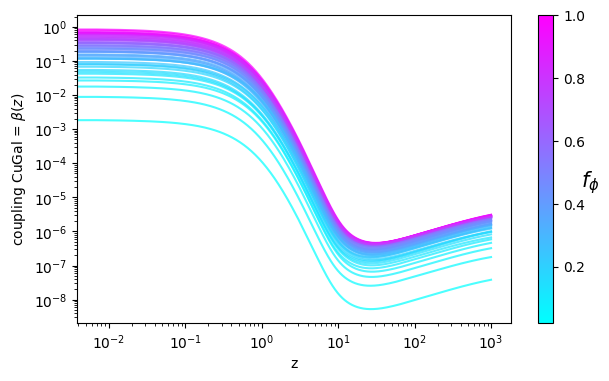

In [45]:
## Plotting ##

cmap = matplotlib.colormaps['cool']

fig, ax = plt.subplots(1,1, figsize=(7,4),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

mu_arr = []
Omega_m = []
E_CuGal = []
E_LCDM = []

# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
for i in range(len(a_n[0])):

    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_expansion.txt".format(i))
    
    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    Omega_m.append(sample_new[0][i])
    E_CuGal.append(E_a_today)
    E_LCDM.append(E_a_GR)
    
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    coupling = force_today.T[2]
    mu_arr.append(coupling + 1)
    ax.plot(1/a_today -1, coupling, alpha=0.7, color = cmap(frac0[i]))
    
ax.set_xscale("log")
ax.set_xlabel("z")

ax.set_ylabel(r"coupling CuGal = $\beta(z)$")
ax.set_yscale("log")

theta = sample_new[-1]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))
print(a_n[4][38])
print(a_n[4][14])
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)



37
14
0.9673
0.8959


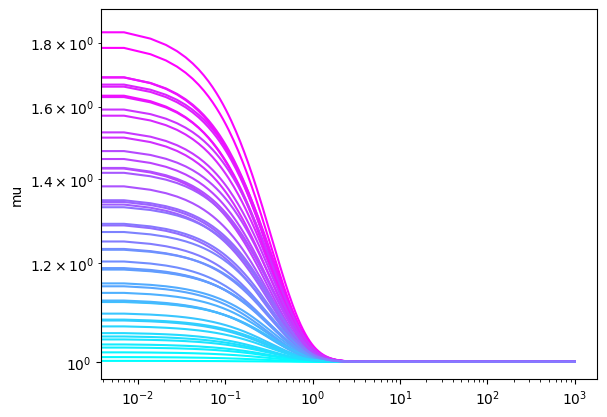

In [34]:
for i in range(len(a_n[0])):
    plt.loglog(1/a_today -1, mu_arr[i], color = cmap(frac0[i]))

plt.ylabel("mu")


theta = sample_new[-1]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))
print(a_n[4][38])
print(a_n[4][14])
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)

37
14
0.9673
0.8959


(0.005, 1000.0)

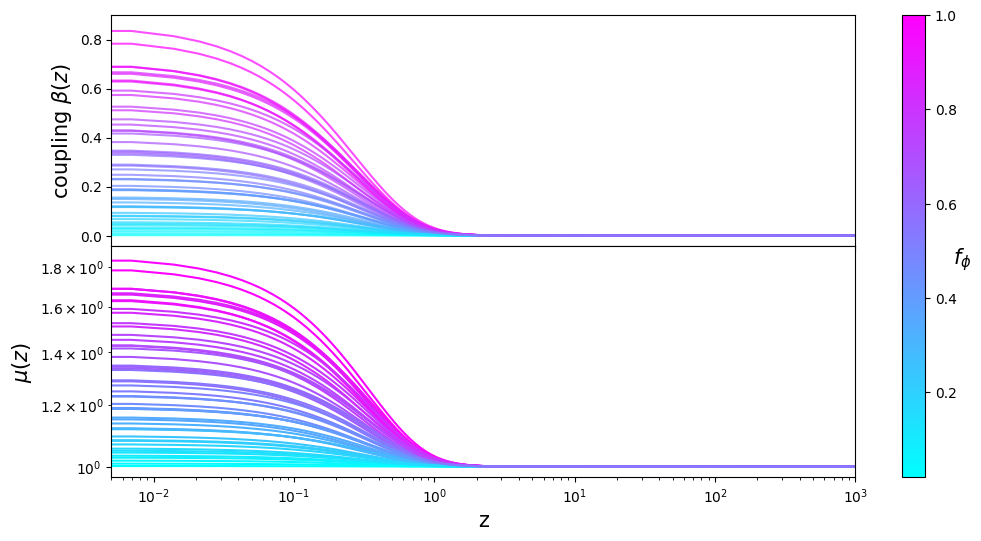

In [35]:
## Plotting ##


fig, ax = plt.subplots(2,1, figsize=(12,6),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

sample_new = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker').T

theta = sample_new[-1]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))
print(a_n[4][38])
print(a_n[4][14])
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)


# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
for i in range(len(a_n[0])):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_expansion.txt".format(i))

    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_force.txt".format(i))

    chiD_today = force_today.T[1]
    coupling = force_today.T[2]

    ax[0].plot(1/a_today -1, coupling, alpha=0.7, color = cmap(frac0[i]))
    ax[1].loglog(1/a_today -1, mu_arr[i], color = cmap(frac0[i]))

ax[0].set_xscale("log")
ax[1].set_xlabel("z", fontsize=15)
ax[0].set_ylabel(r"coupling $\beta(z)$", fontsize=15)

ax[1].set_ylabel(r"$\mu(z)$", fontsize=15)
ax[1].set_xlim(5e-3,1e3)

#plt.savefig('/home/c2042999/PCA_project/HiCOLA_frontend.pdf' , bbox_inches='tight')


In [36]:
def solverGrowth_mu(y,a,a_arr, mu_arr,E_arr,Omega_m):
    mu = CubicSpline(a_arr,mu_arr)(a)
    E_val = CubicSpline(a_arr,E_arr)(a)

    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*Omega_m*D*mu/(2*E_val*a**2)]
    return ydot


0.000999
1.0


Text(0.5, 0, 'z')

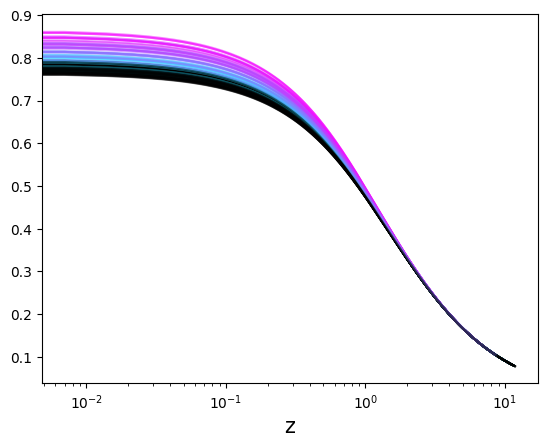

In [57]:
# Doesn't work - growth doesn't go far out enough
"""ratio_growth_new = []


cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)

print(a_today[0])
print(a_today[-1])
for i in range(50):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_expansion.txt".format(i))

    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    idx_matterdom = np.argmax(wm*a_today**(-3)/E_a_today**2/h**2)
    idx_matterdom_gr = np.argmax(wm*a_today**(-3)/E_a_GR**2/h**2)

    a_today_new = a_today[idx_matterdom:]
    a_today_new_gr = a_today[idx_matterdom_gr:]
    
    Soln = odeint(solverGrowth_mu, [a_today_new[0], (E_CuGal[i][idx_matterdom]*a_today_new[0]**3)], a_today_new, \
                  args=(a_today_new, mu_arr[i][idx_matterdom:],E_CuGal[i][idx_matterdom:],Omega_m[i]), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    
    Soln = odeint(solverGrowth_mu, [a_today_new_gr[0], (E_LCDM[i][idx_matterdom_gr]*a_today_new_gr[0]**3)], a_today_new_gr,\
                  args=(a_today_new_gr, np.ones(len(a_today_new_gr)),E_LCDM[i][idx_matterdom_gr:],Omega_m[i]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    
    D_a_norm = Delta / (Delta[0] / a_today_new[0])
    D_a_norm_GR = Delta_GR / (Delta_GR[0] / a_today_new_gr[0])

    plt.semilogx(1/a_today_new - 1, D_a_norm, alpha= 0.5, color = cmap(frac0[i]))
    plt.semilogx(1/a_today_new_gr - 1, D_a_norm_GR, "k", alpha= 0.5)
    
    #D_a_norm_GR = Delta_GR / (CubicSpline(a_today,Delta_GR)(1/(z_matterdom_gr[i]+1)) / (1/(z_matterdom_gr[i]+1)))
    
    
    # We have D_norm(a) = D_(a) * D(a_matterdom)/a - below we ignore the a factor because it is the same in both
    ratio_growth_new.append(D_a_norm[find_idxnearest(z_array, 49)]/D_a_norm_GR[find_idxnearest(z_array, 49)])
    
plt.xlabel("z", fontsize=15)
"""
""""""

0.000999
1.0
0.000999


Text(0.5, 0, 'z')

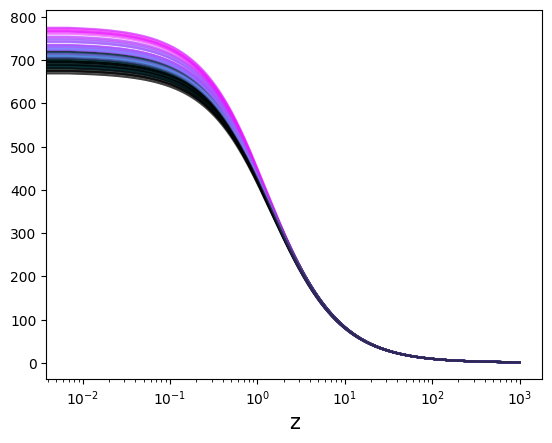

In [62]:

ratio_growth_new = []

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)

print(a_today[0])
print(a_today[-1])
print(np.min(a_today))

for i in range(len(a_n[0])):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_expansion.txt".format(i))
    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    E_a_today = expansion_today.T[1]
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    idx_matterdom = np.argmax(wm*a_today**(-3)/E_a_today**2/h**2)
    idx_matterdom_gr = np.argmax(wm*a_today**(-3)/E_a_GR**2/h**2)

    Soln = odeint(solverGrowth_mu, [a_today[0], (E_CuGal[i][0]*a_today[0]**3)], a_today, \
                  args=(a_today, mu_arr[i],E_CuGal[i],Omega_m[i]), mxstep=int(1e4))
    
    Delta = Soln.T[0]/Soln.T[0][0]
    
    Soln = odeint(solverGrowth_mu, [a_today[0], (E_LCDM[i][0]*a_today[0]**3)], a_today,\
                  args=(a_today, np.ones(len(a_today)),E_LCDM[i],Omega_m[i]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]/Soln.T[0][0]

    plt.semilogx(1/a_today - 1, Delta, alpha= 0.5, color = cmap(frac0[i]))
    plt.semilogx(1/a_today - 1, Delta_GR, "k", alpha= 0.5)

    D_a_norm = Delta / ((CubicSpline(a_today,Delta)(a_today[idx_matterdom])) / a_today[idx_matterdom])

    D_a_norm_GR = Delta_GR / ((CubicSpline(a_today,Delta_GR)(a_today[idx_matterdom_gr])) / a_today[idx_matterdom_gr])
    
    
    # We have D_norm(a) = D_(a) * D(a_matterdom)/a - below we ignore the a factor because it is the same in both
    ratio_growth_new.append(D_a_norm[find_idxnearest(a_today, 0.02)]/D_a_norm_GR[find_idxnearest(a_today, 0.02)])
    
plt.xlabel("z", fontsize=15)


/tmp/ipykernel_1368965/1360251570.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])


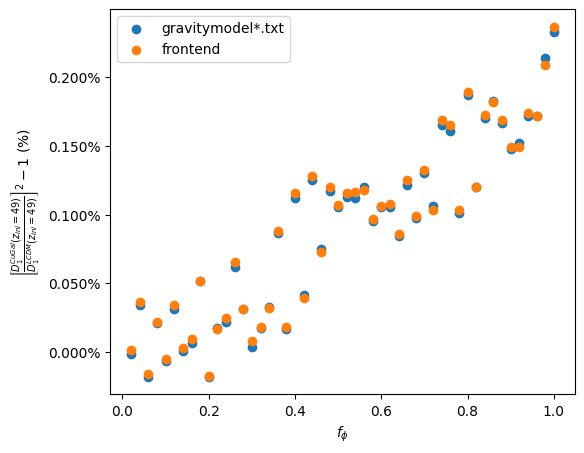

In [63]:
f, ax = plt.subplots(1,1, figsize=(6, 5))

ax.scatter(f_phi, (np.array(ratio_growth)**2 - 1), label="gravitymodel*.txt")
ax.scatter(f_phi, (np.array(ratio_growth_new)**2 - 1), label="frontend")

vals = ax.get_yticks()
ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])

ax.set_ylabel(r"$\left[\frac{D_1^{CuGal}(z_{ini}=49)}{D_1^{LCDM}(z_{ini}=49)}\right]^2 -1$ (%)")
ax.set_xlabel(r"$f_\phi$")
ax.legend()

## From the frontend files (at a fixed cosmology, with smoothing)

48
49


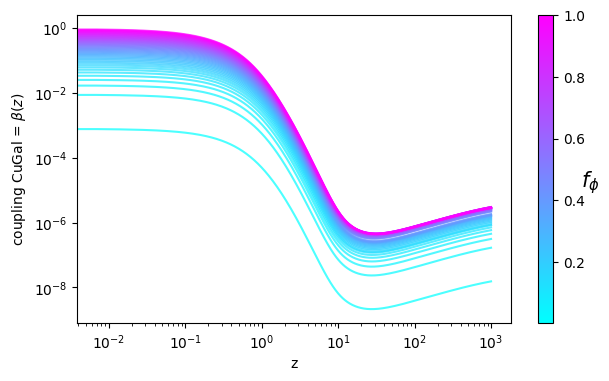

In [19]:
## Plotting ##

f_phi = np.linspace(0.002,1.0,50)

cmap = matplotlib.colormaps['cool']

fig, ax = plt.subplots(1,1, figsize=(7,4),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

mu_arr = []
Omega_m = []
E_CuGal = []
E_LCDM = []

# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
for i in range(len(a_n[0])):

    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output/horndeski_model_run_{}_expansion.txt".format(i))
    
    h = 0.7307
    wm = (0.1274 + 0.02196)
    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    wr = 4.28e-5
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    Omega_m.append(sample_new[0][i])
    E_CuGal.append(E_a_today)
    E_LCDM.append(E_a_GR)
    
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    coupling = force_today.T[2]
    mu_arr.append(coupling + 1)
    ax.plot(1/a_today -1, coupling, alpha=0.7, color = cmap(frac0[i]))
    
ax.set_xscale("log")
ax.set_xlabel("z")

ax.set_ylabel(r"coupling CuGal = $\beta(z)$")
ax.set_yscale("log")

theta = f_phi
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)



48
49


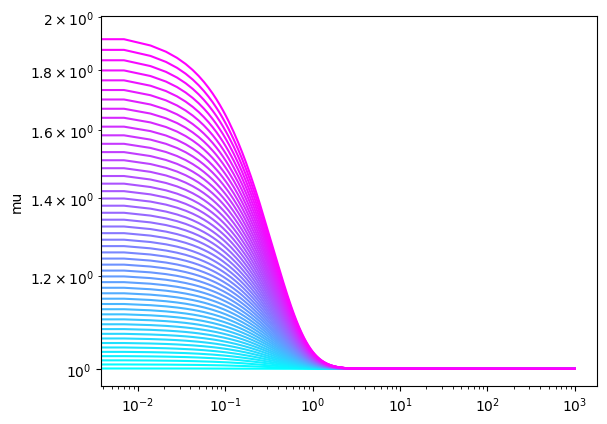

In [102]:
for i in range(len(a_n[0])):
    plt.loglog(1/a_today -1, mu_arr[i], color = cmap(frac0[i]))

plt.ylabel("mu")


theta = f_phi
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)

48
49


(0.005, 1000.0)

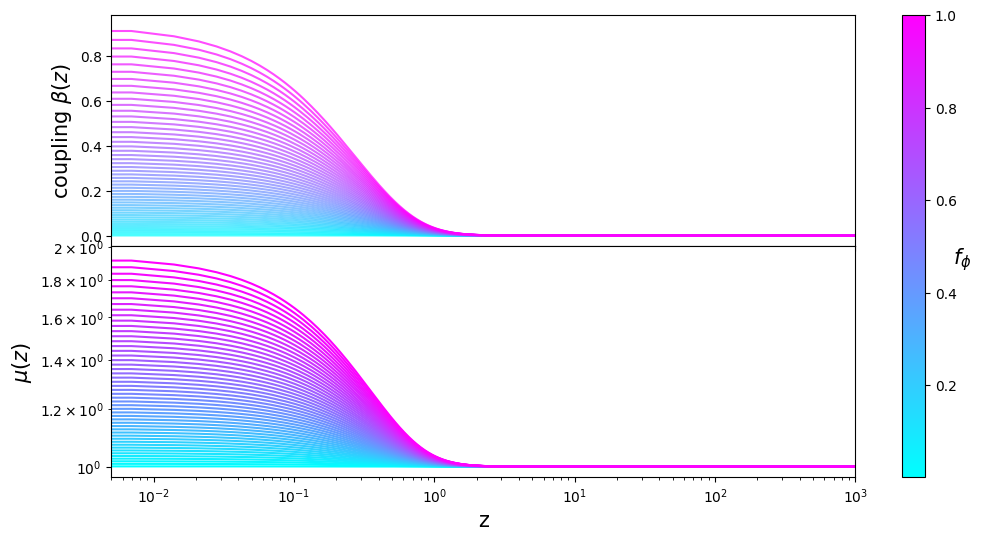

In [103]:
## Plotting ##


fig, ax = plt.subplots(2,1, figsize=(12,6),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

sample_new = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker').T

theta = f_phi
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)


# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
for i in range(len(a_n[0])):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output/horndeski_model_run_{}_expansion.txt".format(i))

    h = 0.7307
    wm = (0.1274 + 0.02196)

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    wr = 4.28e-5
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output/horndeski_model_run_{}_force.txt".format(i))

    chiD_today = force_today.T[1]
    coupling = force_today.T[2]

    ax[0].plot(1/a_today -1, coupling, alpha=0.7, color = cmap(frac0[i]))
    ax[1].loglog(1/a_today -1, mu_arr[i], color = cmap(frac0[i]))

ax[0].set_xscale("log")
ax[1].set_xlabel("z", fontsize=15)
ax[0].set_ylabel(r"coupling $\beta(z)$", fontsize=15)

ax[1].set_ylabel(r"$\mu(z)$", fontsize=15)
ax[1].set_xlim(5e-3,1e3)

#plt.savefig('/home/c2042999/PCA_project/HiCOLA_frontend.pdf' , bbox_inches='tight')


48
49


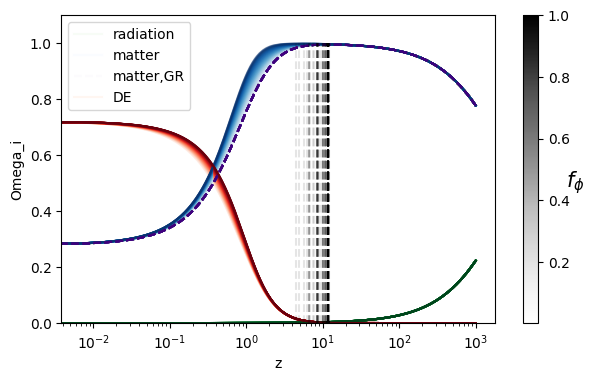

In [104]:
## Plotting ##

fig, ax = plt.subplots(1,1, figsize=(7,4),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

mu_arr = []
Omega_m = []
E_CuGal = []
E_LCDM = []

z_matterdom = []
z_matterdom_gr = []

# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
for i in range(len(a_n[0])):

    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output/horndeski_model_run_{}_expansion.txt".format(i))
    
    h = 0.7307
    wm = (0.1274 + 0.02196)

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]
    wr = 4.28e-5
    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    Omega_m.append(wm/h**2)
    E_CuGal.append(E_a_today)
    E_LCDM.append(E_a_GR)
    
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    coupling = force_today.T[2]
    mu_arr.append(coupling + 1)
    cmap = matplotlib.colormaps['Greens']
    ax.plot(1/a_today -1, wr*a_today**(-4)/E_a_today**2/h**2, alpha=0.9, color = cmap(frac0[i]))
    cmap = matplotlib.colormaps['Blues']
    ax.plot(1/a_today -1, wm*a_today**(-3)/E_a_today**2/h**2, alpha=0.5, color = cmap(frac0[i]))

    cmap = matplotlib.colormaps['Purples']
    ax.plot(1/a_today -1, wm*a_today**(-3)/E_a_GR**2/h**2, alpha=1,linestyle="--", color = cmap(frac0[i]))
    
    cmap = matplotlib.colormaps['Reds']
    ax.plot(1/a_today -1, ((h**2 - wm -wr)/E_a_today**2)/h**2, alpha=0.9, color=cmap(frac0[i]))

    z_matterdom.append((1/a_today -1)[np.argmax(wm*a_today**(-3)/E_a_today**2/h**2)])
    z_matterdom_gr.append((1/a_today -1)[np.argmax(wm*a_today**(-3)/E_a_GR**2/h**2)])

ax.plot([z_matterdom,z_matterdom], [0,1], "k--", alpha=0.1)
ax.plot([z_matterdom_gr,z_matterdom_gr], [0,1], "k--", alpha=0.1)

ax.set_xlabel("z")

ax.legend(["radiation", "matter", "matter,GR", "DE"])
ax.set_ylabel(r"Omega_i")
ax.set_xscale("log")
ax.set_ylim(0,1.1)
theta = f_phi
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))

cmap = matplotlib.colormaps['Greys']

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)




In [105]:
def solverGrowth_mu(y,a,a_arr, mu_arr,E_arr,Omega_m):
    mu = CubicSpline(a_arr,mu_arr)(a)
    E_val = CubicSpline(a_arr,E_arr)(a)

    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*Omega_m*D*mu/(2*E_val*a**2)]
    return ydot


0.000999
1.0
0.000999


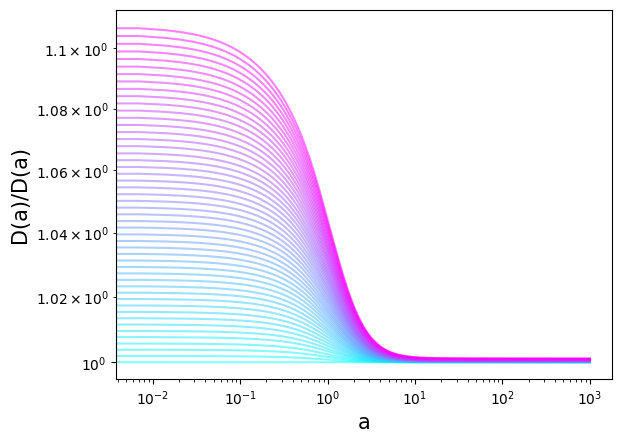

In [106]:
############### NEW VERSION ##################

cmap = matplotlib.colormaps['cool']

ratio_growth_new = []

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)

print(a_today[0])
print(a_today[-1])
print(np.min(a_today))

############### DO GR ##################

expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output/horndeski_model_run_0_expansion.txt")
h = 0.7307
wm = (0.1274 + 0.02196)
wr = 4.28e-5

E_a_GR = expansion_today.T[1]

#########################################
for i in range(len(a_n[0])):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output/horndeski_model_run_{}_expansion.txt".format(i))
    h = 0.7307
    wm = (0.1274 + 0.02196)

    E_a_today = expansion_today.T[1]
    E_a_GR_analytic = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h
    E_a_today = savgol_filter(E_a_today/E_a_GR,100, 3) * E_a_GR_analytic
    wr = 4.28e-5

    idx_matterdom = np.argmax(wm*a_today**(-3)/E_a_today**2/h**2)
    idx_matterdom_gr = np.argmax(wm*a_today**(-3)/E_a_GR_analytic**2/h**2)

    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output/horndeski_model_run_{}_force.txt".format(i))

    coupling = force_today.T[2]
    mu = (coupling + 1)
    
    Soln = odeint(solverGrowth_mu, [a_today[0], (E_a_today[0]*a_today[0]**3)], a_today, \
                  args=(a_today, mu,E_a_today,wm/h**2), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    
    Soln = odeint(solverGrowth_mu, [a_today[0], (E_a_GR_analytic[0]*a_today[0]**3)], a_today,\
                  args=(a_today, np.ones(len(a_today)),E_a_GR_analytic,wm/h**2), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    D_a_norm = Delta / ((CubicSpline(a_today,Delta)(a_today[idx_matterdom])) / a_today[idx_matterdom])

    D_a_norm_GR = Delta_GR / ((CubicSpline(a_today,Delta_GR)(a_today[idx_matterdom_gr])) / a_today[idx_matterdom_gr])
    
    plt.semilogx(1/a_today - 1, D_a_norm/D_a_norm_GR, alpha= 0.5, color = cmap(frac0[i]))

    ratio_growth_new.append(D_a_norm/D_a_norm_GR)
    #ratio_growth_new.append(D_a_norm[find_idxnearest(a_today, 0.02)]/D_a_norm_GR[find_idxnearest(a_today, 0.02)])

plt.xlabel("a", fontsize=15)
plt.ylabel("D(a)/D(a)", fontsize=15)

#plt.xlim(1e-3,1e-2)
#plt.ylim(1e-3,3e-2)
plt.yscale("log")

(50, 1000)


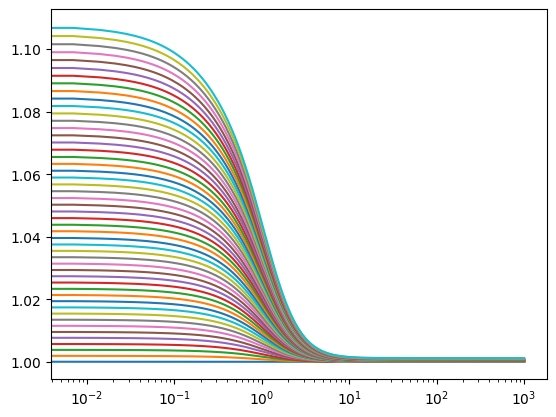

In [107]:
print(np.array(ratio_growth_new).shape)
for i in range(50):
    plt.plot(1/a_today - 1,ratio_growth_new[i])

plt.xscale("log")

/tmp/ipykernel_1368965/1258458871.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(['{:,.3%}'.format(x) for x in vals])
/tmp/ipykernel_1368965/1258458871.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(['{:,.3%}'.format(x) for x in vals])
/tmp/ipykernel_1368965/1258458871.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[2].set_yticklabels(['{:,.3%}'.format(x) for x in vals])
/tmp/ipykernel_1368965/1258458871.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[3].set_yticklabels(['{:,.3%}'.format(x) for x in vals])


Text(0, 0.5, '$z_i=49$')

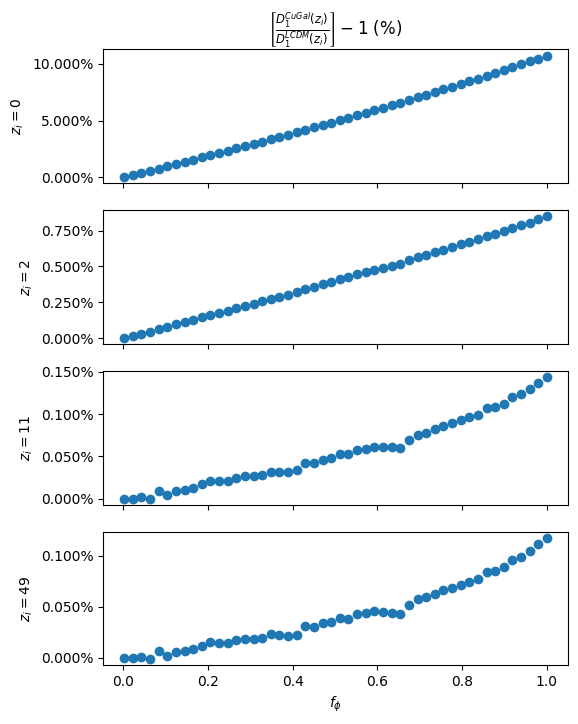

In [108]:
f, ax = plt.subplots(4,1, figsize=(6, 8), sharex=True)
fig.subplots_adjust(wspace=0)

ax[0].set_title(r"$\left[\frac{D_1^{CuGal}(z_i)}{D_1^{LCDM}(z_i)}\right] - 1$ (%)")
ax[3].set_xlabel(r"$f_\phi$")

idx = 999
ax[0].scatter(f_phi, (np.array(ratio_growth_new).T[idx] - 1))
vals = ax[0].get_yticks()
ax[0].set_yticklabels(['{:,.3%}'.format(x) for x in vals])
ax[0].set_ylabel(r"$z_i={}$".format(np.int(1/a_today[idx] - 1)))

idx = 800
ax[1].scatter(f_phi, (np.array(ratio_growth_new).T[idx] - 1))
vals = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.3%}'.format(x) for x in vals])
ax[1].set_ylabel(r"$z_i={}$".format(np.int(1/a_today[idx] - 1)))

idx = np.argmax(wm*a_today**(-3)/E_a_GR**2/h**2)
ax[2].scatter(f_phi, (np.array(ratio_growth_new).T[idx] - 1))
vals = ax[2].get_yticks()
ax[2].set_yticklabels(['{:,.3%}'.format(x) for x in vals])
ax[2].set_ylabel(r"$z_i={}$".format(np.int(1/a_today[idx] - 1)))

idx = np.argmin(np.abs(a_today - 0.02))
ax[3].scatter(f_phi, (np.array(ratio_growth_new).T[idx] - 1))
vals = ax[3].get_yticks()
ax[3].set_yticklabels(['{:,.3%}'.format(x) for x in vals])
ax[3].set_ylabel(r"$z_i={}$".format(np.int(1/a_today[idx] - 1)))

/tmp/ipykernel_1368965/4260398063.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])


Text(0, 0.5, '$z_i=49$')

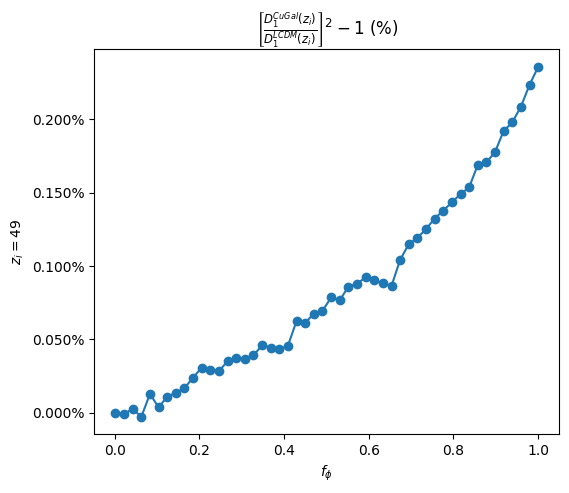

In [109]:
f, ax = plt.subplots(1,1, figsize=(6, 5), sharex=True)
fig.subplots_adjust(wspace=0)

ax.set_title(r"$\left[\frac{D_1^{CuGal}(z_i)}{D_1^{LCDM}(z_i)}\right]^2 - 1$ (%)")
ax.set_xlabel(r"$f_\phi$")

idx = np.argmin(np.abs(a_today - 0.02))
ax.plot(f_phi, (np.array(ratio_growth_new).T[idx]**2 ) - 1)
ax.scatter(f_phi, (np.array(ratio_growth_new).T[idx]**2 ) - 1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])
ax.set_ylabel(r"$z_i={}$".format(np.int(1/a_today[idx] - 1)))


In [110]:
print((np.array(ratio_growth_new).T[idx][-1])**2 - 1)

0.0023587792786614603


## From the frontend files (LH, final)

### Get expansion and force files

In [6]:
"""Define tracker functions"""

# If we are on the tracker, we will get the following constraints equations

# For today formalism 
def k_1T(Omg_m, Omg_r, f_phi):
    return 6*f_phi*(Omg_m + Omg_r - 1)

# dS formalism

def E_dS(Omg_m, Omg_r, f_phi):

    return np.sqrt((1-f_phi)*(1-Omg_m-Omg_r)/2 + np.sqrt(
        ((1-f_phi)*(1-Omg_m-Omg_r)/2)**2 + f_phi*(1-Omg_m-Omg_r)
    ))

In [5]:
''' Define useful functions'''

def hypercube_arrays(txt):
    """
    Takes in txt file with (omega_m,n_s,A_s,E_ds,f_phi)
    returns two arrays, one for numerical and one for horndeski array
    # numerical - [h , wr , wb , wc, n_s , A_s]
    # horndeski - [f_phi, H0, k_1, g_31]
    """
    hcube = np.loadtxt(txt).T

    wb = 0.0223*np.ones(len(hcube[0]))
    wr = wr_funct(T_CMB)*np.ones(len(hcube[0]))
    
    n_s = hcube[1]
    A_s = hcube[2]
    h = hcube[3]
    wm = hcube[0]*h**2


    arr_num = [h, wr, wb, wm - wb, n_s, A_s]
    
    return arr_num

def Update_ini(run, f_phi, arr_num, horn_ini, num_ini):
    """
    Updates files num_ini and horn_ini to include the parameters (numerical and MG) from 
    f_phi and
    arr_num = h , wr , wb , wc, n_s , A_s
    """
    ## Horndeski params
    h , wr , wb , wc, n_s , A_s = arr_num
    config_h = ConfigObj(horn_ini)

    f_phi = 0.0
    k1_track = k_1T((wc + wb)/h**2, wr/h**2, f_phi)

    keys_h = config_h.keys()
    
    config_h[keys_h[1]] = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR'
    config_h[keys_h[0]] = 'horndeski_model'
    
    config_h[keys_h[2]] = 'k_1*X'
    config_h[keys_h[3]] = 'g_31*X'
    config_h[keys_h[4]] = '0.5'

    config_h[keys_h[7]] = str(k1_track)
    config_h[keys_h[8]] = str("1")
    config_h[keys_h[9]] = str(f_phi)
    config_h[keys_h[10]] = str("1")
    config_h[keys_h[11]] = str("1")
    config_h[keys_h[20]] = str("False")
    config_h[keys_h[22]] = str("1")
    
    ## Numerical params
    config_n = ConfigObj(num_ini)
    keys_n = config_n.keys()
    
    config_n[keys_n[0]] = 'run_'+str(run)

    
    config_n[keys_n[6]] = str(h)
    config_n[keys_n[7]] = str(wr)
    config_n[keys_n[8]] = str(wb)
    config_n[keys_n[9]] = str(wc)
    config_h.filename = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini'
    config_n.filename = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'
    config_h.write(); config_n.write()

In [120]:
"""!!!!! CAREFUL WHEN RUNNING THIS deletes a whole directory of frontend parameter files"""
### Run frontend for all different .ini files

#command = 'cd; rm -r /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/'
#os.system(command)
#command = 'cd /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/; mkdir Output'
#os.system(command)
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker'

a_n = hypercube_arrays(txt)
for i in range(len(np.array(a_n).T)):
    Update_ini(str(i), 0.0, np.array(a_n).T[i], '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_parameters.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_parameters.ini')
    command = 'cd ; cd /home/c2042999/HiCOLA_env/Hi-COLA; python3 -m HiCOLA.Frontend.generate_simulation_input /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'
    os.system(command)
    

/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.31051391819899116
Omega_r0 = 9.213906405331266e-05
Omega_lambda0 = 0.6893939427369555
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102230411687688e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.32665203041516677
Omega_r0 = 9.774336922284059e-05
Omega_lambda0 = 0.6732502262156104
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.32890386002672617
Omega_r0 = 8.51916347681017e-05
Omega_lambda0 = 0.6710109483385057
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2990671176735642
Omega_r0 = 8.008364278509274e-05
Omega_lambda0 = 0.7008527986836507
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30826208858743176
Omega_r0 = 8.287317173282511e-05
Omega_lambda0 = 0.6916550382408354
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -6.617444900424222e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3219607187244181
Omega_r0 = 8.461100434076755e-05
Omega_lambda0 = 0.6779546702712411
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -2.0686327744039858e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3161434922278895
Omega_r0 = 8.118833466142381e-05
Omega_lambda0 = 0.6837753194374491
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -3.722993900902428e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3046966917024627
Omega_r0 = 9.558812411114278e-05
Omega_lambda0 = 0.6952077201734261
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2806771758458292
Omega_r0 = 9.850487286093158e-05
Omega_lambda0 = 0.7192243192813099
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -2.0686327744039858e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.32421254833597746
Omega_r0 = 0.00010631823708039753
Omega_lambda0 = 0.6756811334269421
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.303570776896683
Omega_r0 = 0.00010718233212844632
Omega_lambda0 = 0.6963220407711885
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.31745705950129927
Omega_r0 = 0.00011151916321285007
Omega_lambda0 = 0.6824314213354878
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3116398330047709
Omega_r0 = 8.061822523230727e-05
Omega_lambda0 = 0.6882795487699968
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.31276574781055055
Omega_r0 = 0.00010470940927878353
Omega_lambda0 = 0.6871295427801707
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -3.722993900902428e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3093880033932115
Omega_r0 = 0.00010076008881497786
Omega_lambda0 = 0.6905112365179735
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30582260650824244
Omega_r0 = 8.953342312591206e-05
Omega_lambda0 = 0.6940878600686317
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -6.617444900424222e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.32308663353019773
Omega_r0 = 0.00010151500047344934
Omega_lambda0 = 0.6768118514693289
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -2.0686327744039858e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3300297748325059
Omega_r0 = 0.00011060220763098479
Omega_lambda0 = 0.6698596229598631
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 3.032693018334745e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.318582974307079
Omega_r0 = 9.48982361351296e-05
Omega_lambda0 = 0.6813221274567859
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 3.032693018334745e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.29212397637125614
Omega_r0 = 8.764259101036584e-05
Omega_lambda0 = 0.7077883810377334
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.28630674987472765
Omega_r0 = 0.00011239841733880367
Omega_lambda0 = 0.7135808517079336
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2909980615654764
Omega_r0 = 9.997233679552532e-05
Omega_lambda0 = 0.7089019660977282
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.27485994934930075
Omega_r0 = 9.350338581260851e-05
Omega_lambda0 = 0.7250465472648867
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2782376937666398
Omega_r0 = 8.403628974775595e-05
Omega_lambda0 = 0.7216782699436125
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3208348039186383
Omega_r0 = 9.016554574334539e-05
Omega_lambda0 = 0.6790750305356184
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -6.617444900424222e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.285180835068948
Omega_r0 = 9.632453268566925e-05
Omega_lambda0 = 0.7147228403983663
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3277779452209465
Omega_r0 = 0.0001038749871970167
Omega_lambda0 = 0.6721181797918565
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -9.926167350636332e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3311556896382855
Omega_r0 = 9.283590393082295e-05
Omega_lambda0 = 0.6687514744577837
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 3.032693018334745e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.31501757742210984
Omega_r0 = 8.703676846402573e-05
Omega_lambda0 = 0.6848953858094262
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102230411687688e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3197088891128586
Omega_r0 = 7.848273802170923e-05
Omega_lambda0 = 0.6802126281491198
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3138916626163303
Omega_r0 = 9.92345360927864e-05
Omega_lambda0 = 0.6860091028475769
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2874326646805074
Omega_r0 = 9.148611211282915e-05
Omega_lambda0 = 0.7124758492073797
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.27598586415508053
Omega_r0 = 7.955436001596647e-05
Omega_lambda0 = 0.7239345814849035
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -2.0686327744039858e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2829290054573886
Omega_r0 = 8.581103043716265e-05
Omega_lambda0 = 0.7169851835121743
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3001930324793439
Omega_r0 = 9.703006098513811e-05
Omega_lambda0 = 0.6997099374596709
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2966276355943749
Omega_r0 = 8.640407860487049e-05
Omega_lambda0 = 0.7032859603270203
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -3.722993900902428e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.29324989117703576
Omega_r0 = 8.34359760361184e-05
Omega_lambda0 = 0.7066666728469281
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2943758059828155
Omega_r0 = 0.0001088955553548098
Omega_lambda0 = 0.7055152984618298
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.288558579486287
Omega_r0 = 7.900134501209224e-05
Omega_lambda0 = 0.7113624191687009
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30244486209090327
Omega_r0 = 8.173403515109921e-05
Omega_lambda0 = 0.6974734038739456
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2818030906516089
Omega_r0 = 8.231604274556115e-05
Omega_lambda0 = 0.7181145933056455
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3253384631417571
Omega_r0 = 8.825476091510492e-05
Omega_lambda0 = 0.6745732820973278
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.30131894728512365
Omega_r0 = 9.084007646451615e-05
Omega_lambda0 = 0.6985902126384118
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.28987214675969675
Omega_r0 = 0.00010801070258941212
Omega_lambda0 = 0.7100198425377139
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2840549202631683
Omega_r0 = 0.000103093648654285
Omega_lambda0 = 0.7158419860881774
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2977535504001546
Omega_r0 = 0.00010550922363064476
Omega_lambda0 = 0.7021409403762148
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -6.617444900424222e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.3069485213140221
Omega_r0 = 0.00010974390531802624
Omega_lambda0 = 0.6929417347806598
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230246251565e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.27711177896086014
Omega_r0 = 0.00010232109280987637
Omega_lambda0 = 0.72278589994633
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.2793636085724196
Omega_r0 = 8.890792470443747e-05
Omega_lambda0 = 0.720547483502876
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = -1.6543612251060553e-24
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


/home/c2042999/HiCOLA_env/3.7.12/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:47: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  warn("At least one element of `rtol` is too small. "
<lambdifygenerated-13>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return 2.0*E**2.0*g_31*phiprime**3.0/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E + 1.0*(-1.5*E**3.0*g_31*phiprime**2.0*phiprimeprime + Eprime*(-1.5*E**2.0*g_31*phiprime**3.0 + 1.0))/E - 0.5*(2.0*E*Eprime + 1.0*E**2.0*k_1*phiprime**2.0 - 1.0*E**3.0*g_31*phiprime**2.0*(E*phiprimeprime + Eprime*phiprime) + 3.0*E**4.0*g_31*phiprime**3.0)/E**2)
<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)/((1.0 - 1.0*(1.0*E - 0.5*E**3.0*g_31*phiprime**3.0)/E)**2 - 1.0 + 1.0*(1.0*E - 0.5*E

Namespace(input_ini_filenames=['/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/horndeski_today.ini', '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/numerical_today.ini'])
Horndeski functions --------------
K = X*k_1
G_3 = X*g_31
G_4 = 0.500000000000000
Horndeski parameters--------------
horndeski_model model parameters, [k_1, g_31] = [-0.0, 0.9]
Cosmological parameters-----------
Omega_m0 = 0.29550172078859516
Omega_r0 = 9.421578998677968e-05
Omega_lambda0 = 0.704404063421418
Initial conditions----------------
Hubble0 = 1.0
scalar_prime0 = 1.0
Closure parameter is g_31 = 1.1102230411687688e-16
(note: therefore one of the initial conditions or Horndeski model parameters printed above was the guess value)
Files for Hi-COLA numerical simulation being generated.
Files generated. Saved in /home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR


### Get the growth ratio

In [8]:
def wr_funct(T_CMB):
    return 4.48150052e-7*T_CMB**4 *(1+ 3.044*7/8 * (4/11)**(4/3))

T_CMB = 2.72548 # K

37
14


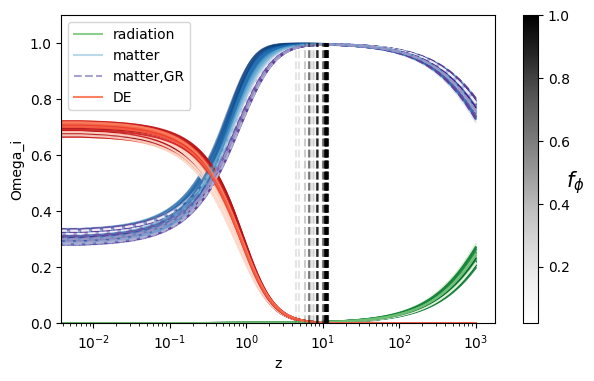

In [10]:
## Plotting ##

sample_new = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker').T
txt = '/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker'
a_n = hypercube_arrays(txt)
cmap = matplotlib.colormaps['viridis']

f_phi = sample_new[-1]

fig, ax = plt.subplots(1,1, figsize=(7,4),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)

mu_arr = []
Omega_m = []
E_CuGal = []
E_LCDM = []

z_matterdom = []
z_matterdom_gr = []
theta = f_phi
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))

# We want Omega_m*h^2 , n_s    , A_s ,h,  f_phi
for i in range(len(a_n[0])):

    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_expansion.txt".format(i))
    
    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    a_today = expansion_today.T[0]
    E_a_today = expansion_today.T[1]

    E_a_GR = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h

    Omega_m.append(wm/h**2)
    E_CuGal.append(E_a_today)
    E_LCDM.append(E_a_GR)
    
    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_force.txt".format(i))

    a_today = force_today.T[0]
    coupling = force_today.T[2]
    mu_arr.append(coupling + 1)
    cmap = matplotlib.colormaps['Greens']
    ax.plot(1/a_today -1, wr*a_today**(-4)/E_a_today**2/h**2, alpha=0.9, color = cmap(frac0[i]))
    cmap = matplotlib.colormaps['Blues']
    ax.plot(1/a_today -1, wm*a_today**(-3)/E_a_today**2/h**2, alpha=0.5, color = cmap(frac0[i]))

    cmap = matplotlib.colormaps['Purples']
    ax.plot(1/a_today -1, wm*a_today**(-3)/E_a_GR**2/h**2, alpha=1,linestyle="--", color = cmap(frac0[i]))
    
    cmap = matplotlib.colormaps['Reds']
    ax.plot(1/a_today -1, ((h**2 - wm -wr)/E_a_today**2)/h**2, alpha=0.9, color=cmap(frac0[i]))

    z_matterdom.append((1/a_today -1)[np.argmax(wm*a_today**(-3)/E_a_today**2/h**2)])
    z_matterdom_gr.append((1/a_today -1)[np.argmax(wm*a_today**(-3)/E_a_GR**2/h**2)])

ax.plot([z_matterdom,z_matterdom], [0,1], "k--", alpha=0.1)
ax.plot([z_matterdom_gr,z_matterdom_gr], [0,1], "k--", alpha=0.1)

ax.set_xlabel("z")

ax.legend(["radiation", "matter", "matter,GR", "DE"])
ax.set_ylabel(r"Omega_i")
ax.set_xscale("log")
ax.set_ylim(0,1.1)

print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))

cmap = matplotlib.colormaps['Greys']

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)




In [11]:
def solverGrowth_mu(y,a,a_arr, mu_arr,E_arr,Omega_m):
    mu = CubicSpline(a_arr,mu_arr)(a)
    E_val = CubicSpline(a_arr,E_arr)(a)

    D , a3EdDda = y
    
    ydot = [a3EdDda / (E_val*a**3), 3*Omega_m*D*mu/(2*E_val*a**2)]
    return ydot


0.000999
1.0
0.000999


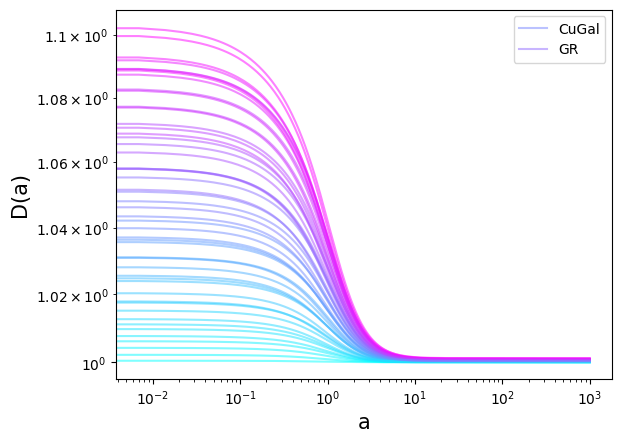

In [12]:
############### NEW VERSION ##################

cmap = matplotlib.colormaps['cool']

ratio_growth_new = []

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0, fontsize=15)

print(a_today[0])
print(a_today[-1])
print(np.min(a_today))


###############################################
for i in range(len(a_n[0])):
    expansion_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_expansion.txt".format(i))
    
    wr = wr_funct(T_CMB)
    h = sample_new[3][i]
    wm = sample_new[0][i]*h**2

    expansion_today_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Growth_comparison_files/Output_GR/horndeski_model_run_{}_expansion.txt".format(i))
    E_a_GR = expansion_today_GR.T[1]

    E_a_today = expansion_today.T[1]
    E_a_GR_analytic = np.sqrt((wm)*a_today**(-3) + wr*a_today**(-4) + (h**2 - (wm) -wr))/h
    E_a_today = savgol_filter(E_a_today/E_a_GR,100, 3) * E_a_GR_analytic

    idx_matterdom = np.argmax(wm*a_today**(-3)/E_a_today**2/h**2)
    idx_matterdom_gr = np.argmax(wm*a_today**(-3)/E_a_GR_analytic**2/h**2)

    force_today = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Backend_input_parameter_files/Output/horndeski_model_run_{}_force.txt".format(i))

    coupling = force_today.T[2]
    mu = (coupling + 1)
    
    Soln = odeint(solverGrowth_mu, [a_today[0], (E_a_today[0]*a_today[0]**3)], a_today, \
                  args=(a_today, mu,E_a_today,wm/h**2), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    
    Soln = odeint(solverGrowth_mu, [a_today[0], (E_a_GR_analytic[0]*a_today[0]**3)], a_today,\
                  args=(a_today, np.ones(len(a_today)),E_a_GR_analytic,wm/h**2), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    D_a_norm = Delta / ((CubicSpline(a_today,Delta)(a_today[idx_matterdom])) / a_today[idx_matterdom])

    D_a_norm_GR = Delta_GR / ((CubicSpline(a_today,Delta_GR)(a_today[idx_matterdom_gr])) / a_today[idx_matterdom_gr])
    
    plt.semilogx(1/a_today - 1, D_a_norm/D_a_norm_GR, alpha= 0.5, color = cmap(frac0[i]))

    ratio_growth_new.append(D_a_norm/D_a_norm_GR)
    #ratio_growth_new.append(D_a_norm[find_idxnearest(a_today, 0.02)]/D_a_norm_GR[find_idxnearest(a_today, 0.02)])

plt.xlabel("a", fontsize=15)
plt.ylabel("D(a)", fontsize=15)
plt.legend(["CuGal", "GR"])
#plt.xlim(1e-3,1e-2)
#plt.ylim(1e-3,3e-2)
plt.yscale("log")

/tmp/ipykernel_2509495/1538221208.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])


Text(0, 0.5, '$z_i=49$')

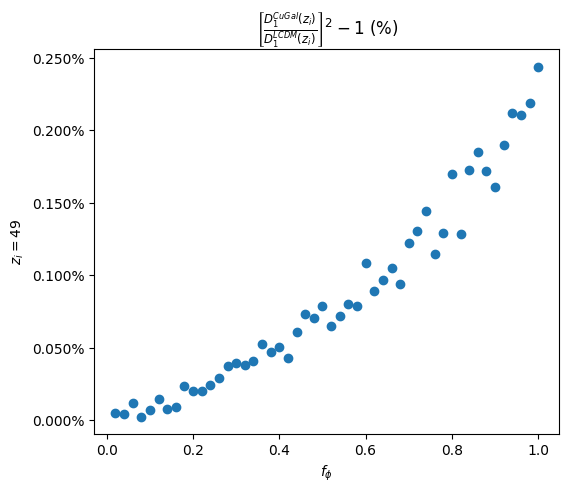

In [13]:
f, ax = plt.subplots(1,1, figsize=(6, 5), sharex=True)
fig.subplots_adjust(wspace=0)
idx = np.argmin(np.abs(a_today - 0.02))


ax.set_title(r"$\left[\frac{D_1^{CuGal}(z_i)}{D_1^{LCDM}(z_i)}\right]^2 - 1$ (%)")
ax.set_xlabel(r"$f_\phi$")

idx = np.argmin(np.abs(a_today - 0.02))
ax.scatter(f_phi, (np.array(ratio_growth_new).T[idx]**2 ) - 1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.3%}'.format(x) for x in vals])
ax.set_ylabel(r"$z_i={}$".format(np.int(1/a_today[idx] - 1)))


In [14]:
print((np.array(ratio_growth_new).T[idx][np.argmax(np.array(ratio_growth_new).T[idx])])**2 - 1)

0.0024380091977316276


# Create P(k) files

Text(0, 0.5, '$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

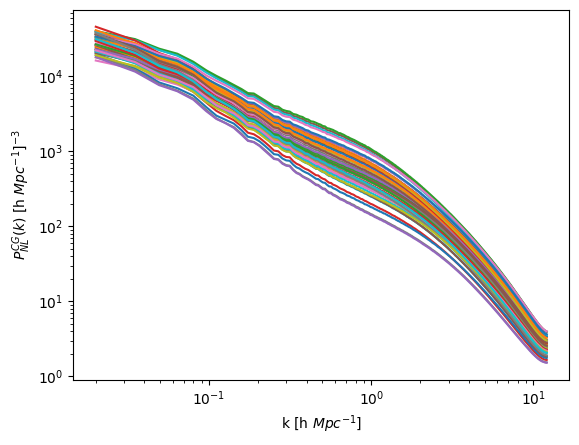

In [131]:
"""Plotting the NL power spectra for the simulations at z = 0, CG"""

for i in range(50):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_pp,Pk_Lin_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    plt.plot(k,(Pk_NL+ Pk_NL_pp)/2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{CG}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")

Text(0, 0.5, '$P^{GR}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$')

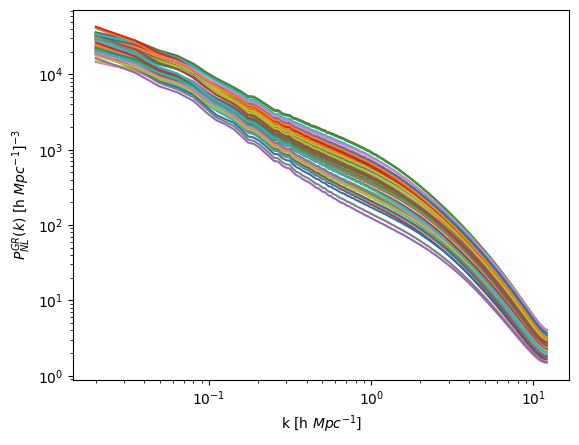

In [132]:
"""Plotting the NL power spectra for the simulations at z = 0, GR"""

for i in range(50):
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_GR_pp,Pk_Lin_GR_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    plt.plot(k,(Pk_NL_GR+ Pk_NL_GR_pp)/2)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"k [h $Mpc^{-1}]$")
#plt.ylabel("$\dfrac{P_{NL}(k)}{P_{lin}(k)}$")
plt.ylabel("$P^{GR}_{NL}(k)$ [h $Mpc^{-1}]^{-3}$")

(768, 21)


Text(0, 0.5, '$B(k, z=0)$')

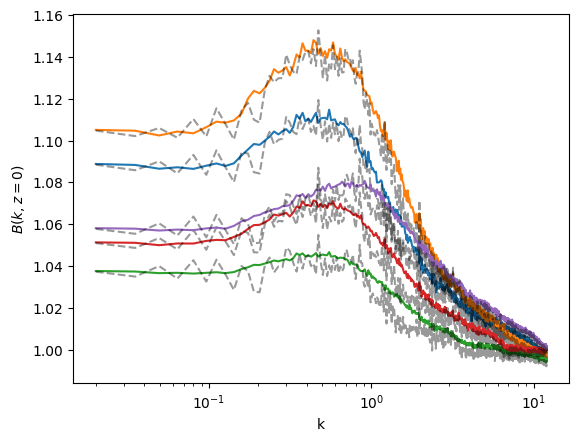

In [13]:
"""Plotting the Boost for the simulations at z = 0"""
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Ratio_pp_avg.npy')
print(arr_loaded.shape)

for i in range(5):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_pp,Pk_Lin_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_GR_pp,Pk_Lin_GR_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    
    Boost = ((Pk_NL+ Pk_NL_pp)/(Pk_NL_GR + Pk_NL_GR_pp)) 
    
    plt.plot(k,Boost)
    plt.plot(k,Boost / arr_loaded[:,0], "k--", alpha=0.4)


plt.xscale("log")
plt.xlabel("k")
plt.ylabel("$B(k, z=0)$")

In [134]:
"""Example for a single point of how to get out P(k) at different z"""
for i in range(1):
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}*'.format(i,i), recursive=True):
        k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
        if c == 0:
            Pk_NL = [Pk_NL_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]
        else:
            Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    """
    print(sorted(z))
    print(Pk_NL[:,0].shape)
    plt.plot(sorted(z),Pk_NL[z.argsort()][:,10], "b")
    plt.scatter(z,Pk_NL[:,10])
    print(Pk_NL[z.argsort()])
    print(z)
    # to check that sorting method for Pk_NL works
    """


In [4]:
"""By the end of this cell, will have 
Boost = Boost(simulation, z, k)  --- WITH GROWTH FACTOR NORMALIZATION INCLUDED!
k = wavevector
z = redshift"""

Boost = np.zeros((50,51,768))

for i in range(50):

    # CG, no phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb*'.format(i,i), recursive=True):

        k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
        
        if c == 0:
            Pk_NL = [Pk_NL_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_NL = np.append(Pk_NL, [Pk_NL_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_NL = Pk_NL[z.argsort()]

    # CG, phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair*'.format(i,i), recursive=True):

        k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
        
        if c == 0:
            Pk_NL_pp = [Pk_NL_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_NL_pp = np.append(Pk_NL_pp, [Pk_NL_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_NL_pp = Pk_NL_pp[z.argsort()]
    
    # GR, no phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_cb*'.format(i,i), recursive=True):
        
        k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T
        
        
        if c == 0:
            Pk_NL_GR = [Pk_NL_GR_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_NL_GR = np.append(Pk_NL_GR, [Pk_NL_GR_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_NL_GR = Pk_NL_GR[z.argsort()]

    # GR, phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_phasepair*'.format(i,i), recursive=True):
        
        k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T
        
        
        if c == 0:
            Pk_NL_GR_pp = [Pk_NL_GR_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_NL_GR_pp = np.append(Pk_NL_GR_pp, [Pk_NL_GR_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_NL_GR_pp = Pk_NL_GR_pp[z.argsort()]

    Boost[i] = ((Pk_NL+ Pk_NL_pp)/(Pk_NL_GR + Pk_NL_GR_pp)) * np.array(ratio_growth_new).T[np.argmin(np.abs(a_today - 0.02))][i]**2

z = sorted(z)


KeyboardInterrupt



In [ ]:
print(['%.3f' % i for i in z])
print(len(z))

In [3]:
"""Plotting the Boost for the simulations at z = 0"""

for i in range(51):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_35_tracker/pofk_my_new_Hi-COLA_simulation_35_tracker_cb_z{}.txt".format(['%.3f' % i for i in z][i])).T
    k, Pk_NL_pp,Pk_Lin_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_35_tracker/pofk_my_new_Hi-COLA_simulation_35_tracker_phasepair_cb_z{}.txt".format(['%.3f' % i for i in z][i])).T
    
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_35_GR_tracker/pofk_my_new_Hi-COLA_simulation_35_GR_tracker_cb_z{}.txt".format(['%.3f' % i for i in z][i])).T
    k, Pk_NL_GR_pp,Pk_Lin_GR_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_35_GR_tracker/pofk_my_new_Hi-COLA_simulation_35_GR_tracker_phasepair_cb_z{}.txt".format(['%.3f' % i for i in z][i])).T
    
    Boost_plot = ((Pk_NL+ Pk_NL_pp)/(Pk_NL_GR+ Pk_NL_GR_pp))
    #plt.plot(k,Boost[35,i,:], "r", alpha=0.6)

    plt.plot(k,Boost_plot,"b--", alpha=0.6)
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("$B(k, z), f_{\phi} =0.02$")

NameError: name 'z' is not defined

Text(0, 0.5, '$B(k, z=0)$')

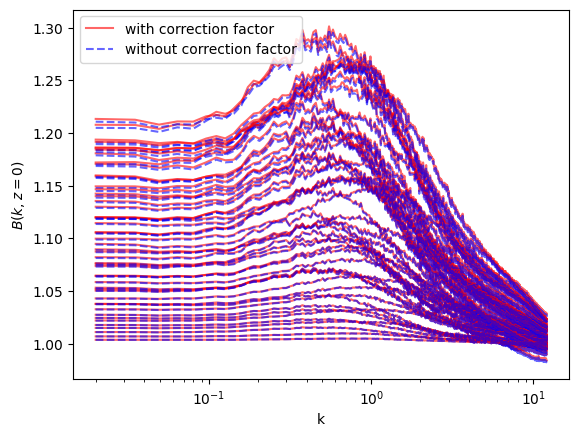

In [147]:
"""Plotting the Boost for the simulations at z = 0"""

for i in range(50):
    k, Pk_NL,Pk_Lin = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_pp,Pk_Lin_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    
    k, Pk_NL_GR,Pk_Lin_GR = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_cb_z0.000.txt".format(i,i)).T
    k, Pk_NL_GR_pp,Pk_Lin_GR_pp = np.loadtxt("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_phasepair_cb_z0.000.txt".format(i,i)).T
    
    Boost_plot = ((Pk_NL+ Pk_NL_pp)/(Pk_NL_GR+ Pk_NL_GR_pp))
    plt.plot(k,Boost[i,0,:], "r", alpha=0.6)

    plt.plot(k,Boost_plot,"b--", alpha=0.6)
plt.xscale("log")
plt.xlabel("k")
plt.legend(["with correction factor", "without correction factor"])
plt.ylabel("$B(k, z=0)$")





Text(0, 0.5, '$B(k, z=0)$')

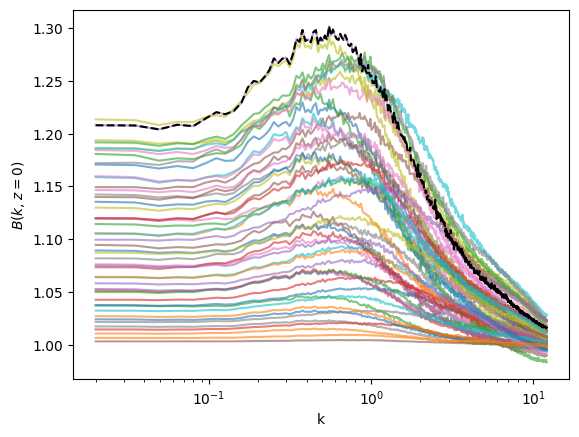

In [141]:
"""Plotting the Boost for the simulations at z = 0 (to compare with cell above)"""

for i in range(50):
    plt.plot(k,Boost[i,0,:], alpha=0.6)

plt.plot(k,Boost[14,0,:], "k--")
plt.xscale("log")
plt.xlabel("k")
plt.ylabel("$B(k, z=0)$")

Text(0, 0.5, '$B(k=0.02 $ h/Mpc $, z)$')

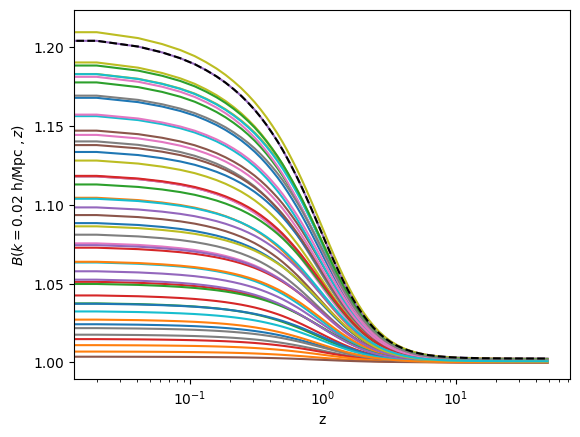

In [142]:
"""Plotting the Boost for the simulations at different z"""

for i in range(50):
    plt.plot(z,Boost[i,:,0])

plt.plot(z,Boost[14,:,0], "k--")
plt.xscale("log")
plt.xlabel("z")
plt.ylabel("$B(k=0.02 $ h/Mpc $, z)$")

In [143]:
"""Saving the Boost
Create a file B_i(k,z) for each of the 50 points i, one file for each z"""

for i in range(51):
    col = ["# B_0(k)"]
    for j in range(49):
        col = np.append(col, "B_{}(k)".format(j+1))
    df = pd.DataFrame(Boost[:,i,:].T, columns= col)

    #specify path for export
    path = r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_z{}.txt'.format(z[i])
    
    #export DataFrame to text file
    with open(path, 'a') as f:
        df_string = df.to_string(header=True, index=False)
        f.write(df_string)

In [144]:
"""Save to zip file"""
zip = zipfile.ZipFile("/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost.zip", "w", zipfile.ZIP_DEFLATED)
for i in range(51):
    # NOTE: move the Packaged_output folder
    path = r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_z{}.txt'.format(z[i])
    zip.write(path,basename(path))
zip.close()

In [145]:
"""Saving z and k"""

df_zk = pd.DataFrame([z,list(k)]).T
df_zk.columns = ["# z", "k (h/Mpc)"]
#export DataFrame to text file
with open(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/z_k.txt', 'w') as f:
    df_string = df_zk.to_string(header=True, index=False)
    f.write(df_string)

In [146]:
"""Saving the Boost to a binary .npy file
Create a file B(sample point,k,z)"""

np.save(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost.npy', Boost)

# Load the saved array
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost.npy')
print(arr_loaded.shape)

(50, 51, 768)


### Getting the Linear Boost (not essential for paper)

In [15]:
"""By the end of this cell, will have 
Boost = Boost(simulation, z, k)  --- WITH GROWTH FACTOR NORMALIZATION INCLUDED!
k = wavevector
z = redshift"""

Boost_Lin = np.zeros((50,51,768))

for i in range(50):

    # CG, no phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_cb*'.format(i,i), recursive=True):

        k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
        
        if c == 0:
            Pk_Lin = [Pk_Lin_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_Lin = np.append(Pk_Lin, [Pk_Lin_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_Lin = Pk_Lin[z.argsort()]

    # CG, phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_tracker/pofk_my_new_Hi-COLA_simulation_{}_tracker_phasepair*'.format(i,i), recursive=True):

        k, Pk_NL_j,Pk_Lin_j = np.loadtxt(filename).T
        
        if c == 0:
            Pk_Lin_pp = [Pk_Lin_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_Lin_pp = np.append(Pk_Lin_pp, [Pk_Lin_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_Lin_pp = Pk_Lin_pp[z.argsort()]
    
    # GR, no phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_cb*'.format(i,i), recursive=True):
        
        k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T
        
        
        if c == 0:
            Pk_Lin_GR = [Pk_Lin_GR_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_Lin_GR = np.append(Pk_Lin_GR, [Pk_Lin_GR_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_Lin_GR = Pk_Lin_GR[z.argsort()]

    # GR, phase reverse
    c = 0
    for filename in glob.glob('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Output_backend/COLA_{}_GR_tracker/pofk_my_new_Hi-COLA_simulation_{}_GR_tracker_phasepair*'.format(i,i), recursive=True):
        
        k, Pk_NL_GR_j,Pk_Lin_GR_j = np.loadtxt(filename).T
        
        
        if c == 0:
            Pk_Lin_GR_pp = [Pk_Lin_GR_j]
            z = [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])]

        else:
            Pk_Lin_GR_pp = np.append(Pk_Lin_GR_pp, [Pk_Lin_GR_j], axis = 0)
            z = np.append(z, [float(filename.split("z",1)[1].split(".",2)[0] + "." + filename.split("z",1)[1].split(".",2)[1])], axis=0)
        c += 1
    # sort Pk from lowest to highest 
    Pk_Lin_GR_pp = Pk_Lin_GR_pp[z.argsort()]

    Boost_Lin[i] = ((Pk_Lin+ Pk_Lin_pp)/(Pk_Lin_GR + Pk_Lin_GR_pp)) * np.array(ratio_growth_new).T[np.argmin(np.abs(a_today - 0.02))][i]**2

z = sorted(z)

In [16]:
"""Saving the Boost to a binary .npy file
Create a file B(sample point,k,z)"""

np.save(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_Lin.npy', Boost_Lin)

# Load the saved array
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_Lin.npy')
print(arr_loaded.shape)

(50, 51, 768)


# Analyse P(k) from files

In [4]:
# Load hypercube

# We have Omega_m , n_s    , A_s  ,   E_ds   ,     f_phi

hypercube = np.loadtxt('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/cosmo_newdesign_tracker')


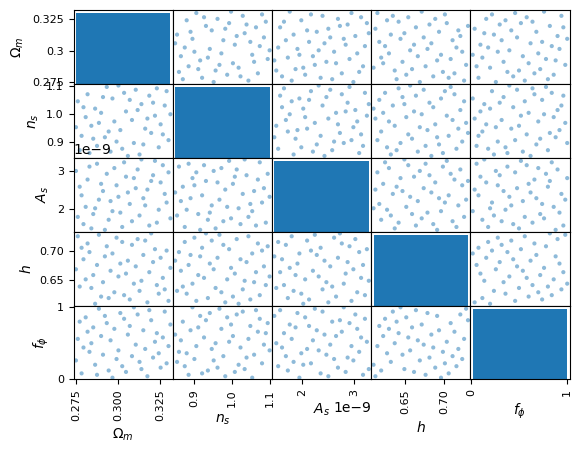

In [7]:
df_theta = pd.DataFrame(hypercube, columns=[r'$\Omega_m$',r'$n_s$', r'$A_s$', r'$h$', r'$f_\phi$'][:len(hypercube)])
pd.plotting.scatter_matrix(df_theta)
plt.savefig('/home/c2042999/PCA_project/Experimental_design.pdf' , bbox_inches='tight')
plt.show()
#print(df_theta['f_phi'])

In [54]:
# Load boost
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost.npy')
print(arr_loaded.shape)


(50, 51, 768)


In [55]:
zk = np.loadtxt(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/z_k.txt') 
z = zk.T[0][~np.isnan(zk.T[0])]
k = zk.T[1]
print(z.shape)
print(k.shape)

(51,)
(768,)


37
14
0.980008
1.0


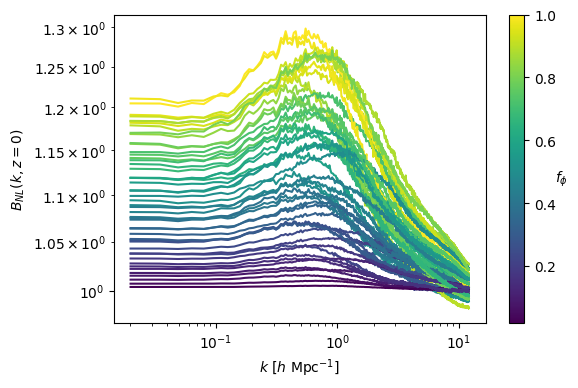

In [89]:
"""Plotting the NL power spectra for the simulations at z = 0"""
# NL spectra: k_lin[i],Pk_hm_fR[i][0]*R[i][0],Pk_hm_GR[i][0]
# hcube = [Omega_c, Omega_b, n_s, A_s, h]
cmap = matplotlib.colormaps['viridis']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)

theta = hypercube.T[4]
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))
print(np.argmax(np.delete(frac0,14)))
print(np.argmax(frac0))
print(hypercube.T[4][38])
print(hypercube.T[4][14])
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$f_{\phi}$', rotation=0)

for i in range(len(arr_loaded)):
        plt.plot(k,arr_loaded[i,0,:], color = cmap(frac0[i]), label="z = 0")


ax.set_ylabel("$B_{NL}(k, z=0)$")

ax.set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

plt.xscale("log")
plt.yscale("log")

plt.show()

NameError: name 'z' is not defined

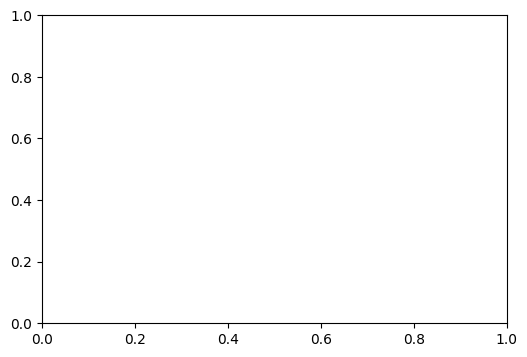

In [126]:
"""Plotting the NL power spectra for the simulations at all z for smallest f_phi"""
# NL spectra: k_lin[i],Pk_hm_fR[i][0]*R[i][0],Pk_hm_GR[i][0]
# hcube = [Omega_c, Omega_b, n_s, A_s, h]
cmap = matplotlib.colormaps['cool']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)

theta = z[:find_idxnearest(z, 1)]
print("z= ", z[:find_idxnearest(z, 1)])
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$z$', rotation=0)

for i in range(len(arr_loaded[0][:find_idxnearest(z, 1)])):
        plt.plot(k,arr_loaded[find_idxnearest(hypercube.T[4], 0),i,:], color = cmap(frac0[i]), label="z = 0")

for i in range(len(arr_loaded[0][find_idxnearest(z, 1):])):
        plt.plot(k,arr_loaded[find_idxnearest(hypercube.T[4], 0),i+ find_idxnearest(z, 1),:], "k--", label="z = 0", alpha=0.5)

print(hypercube.T[4][find_idxnearest(hypercube.T[4], 0)])

ax.set_ylabel("$B_{}(k, z), f_{} = ${}".format('{NL}','\phi', hypercube.T[4][find_idxnearest(hypercube.T[4], 0)]))

ax.set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

plt.xscale("log")
plt.yscale("log")

plt.show()

NameError: name 'z' is not defined

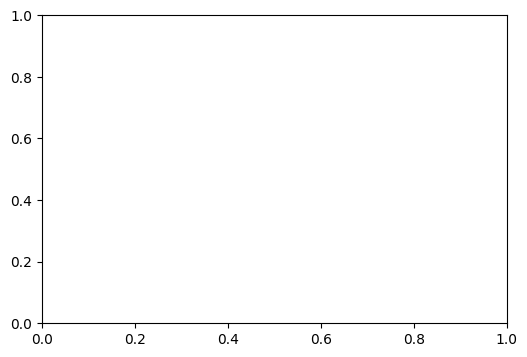

In [127]:
"""Plotting the NL power spectra for the simulations at all z for smallest f_phi"""
# NL spectra: k_lin[i],Pk_hm_fR[i][0]*R[i][0],Pk_hm_GR[i][0]
# hcube = [Omega_c, Omega_b, n_s, A_s, h]
cmap = matplotlib.colormaps['cool']

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6,4))
fig.subplots_adjust(hspace=0)

theta = z
#print("z= ", z)
frac0 = (theta - min(theta))/(max(theta)-min(theta))
norm0 = matplotlib.colors.Normalize(vmin=min(theta), vmax=max(theta))

cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm0, cmap=cmap), ax = ax, orientation='vertical')
cbar.set_label('$z$', rotation=0)

for i in range(len(arr_loaded[0])):
        plt.plot(k,arr_loaded[find_idxnearest(hypercube.T[4], 0),i,:], color = cmap(frac0[i]), label="z = 0", alpha=0.3)
print(hypercube.T[4][find_idxnearest(hypercube.T[4], 0)])

ax.set_ylabel("$B_{}(k, z), f_{} = ${}".format('{NL}','\phi', hypercube.T[4][find_idxnearest(hypercube.T[4], 0)]))

ax.set_xlabel("$k$ [$h$ Mpc$^{-1}$]")

plt.xscale("log")
plt.yscale("log")

plt.show()

# Modify the boost

In [283]:
# Load boost
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost.npy')
print(arr_loaded.shape)


(50, 51, 768)


In [284]:
zk = np.loadtxt(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/z_k.txt') 
z = zk.T[0][~np.isnan(zk.T[0])]
k = zk.T[1]
print(z.shape)
print(k.shape)

(51,)
(768,)


In [ ]:
new_boost = ratio_growth2 * boost

In [15]:
"""Saving the Boost
Create a file B_i(k,z) for each of the 50 points i, one file for each z"""

for i in range(51):
    col = ["# B_0(k)"]
    for j in range(49):
        col = np.append(col, "B_{}(k)".format(j+1))
    df = pd.DataFrame(Boost[:,i,:].T, columns= col)

    #specify path for export
    path = r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_z{}.txt'.format(z[i])
    
    #export DataFrame to text file
    with open(path, 'a') as f:
        df_string = df.to_string(header=True, index=False)
        f.write(df_string)

In [17]:
"""Save to zip file"""
zip = zipfile.ZipFile("Boost.zip", "w", zipfile.ZIP_DEFLATED)
for i in range(51):
    # NOTE: move the Packaged_output folder
    path = r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost_z{}.txt'.format(z[i])
    zip.write(path,basename(path))
zip.close()

In [19]:
"""Saving z and k"""

df_zk = pd.DataFrame([z,list(k)]).T
df_zk.columns = ["# z", "k (h/Mpc)"]
#export DataFrame to text file
with open(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/z_k.txt', 'w') as f:
    df_string = df_zk.to_string(header=True, index=False)
    f.write(df_string)

In [18]:
"""Saving the Boost to a binary .npy file
Create a file B(sample point,k,z)"""

np.save(r'/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost.npy', Boost)

# Load the saved array
arr_loaded = np.load('/home/c2042999/HiCOLA_env/Cubic_galileon_emu-ICGweek/Packaged_output/Boost.npy')
print(arr_loaded.shape)

(50, 51, 768)
